<a href="https://colab.research.google.com/github/ojmakinde/coding.13/blob/main/L04_Shelling_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [L04: Implementing the Shelling Model](https://docs.google.com/document/d/1NtGAKnsfwLRYMYrL74aMVMtTuQRJ1oDjvSFWlmMjpzs/edit?usp=sharing)
Written by Dr. Jan Pearce, Berea College

Complete the code by meeting all linked requirements and fixing all FIXMEs

## Your Name: FIXME

**SUMMARY**: A brief summary description of the design and implementation, including how much your initial design plan evolved, the final result you achieved and the amount of time you spent as a programmer or programmers in accomplishing these results. This should be no more than two paragraphs.

FIXME

**PERSONNEL**: A description of who you worked with and on what sections.  It is expected that all collaboration is done as pair programming together. Also, note these collaborations in the code section itself.

FIXME

**CHALLENGES**: Descriptions of the largest challenges you overcame and what made them challenging.

FIXME

**INNOVATIONS**: Any innovations that were not specifically required by the assignment. These are not required, but should be highlighted if included.

FIXME

**TESTING**: Describe how you tested this work.

FIXME

**ERRORS**: A list in bulleted form of all known errors and deficiencies.

FIXME

**COMMENTS**: A paragraph or so of your own comments on and reactions to the Lab.

FIXME

## Import Libraries

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from urllib.request import urlopen
import random
import numpy as np

## The Schelling Model


Initial State:


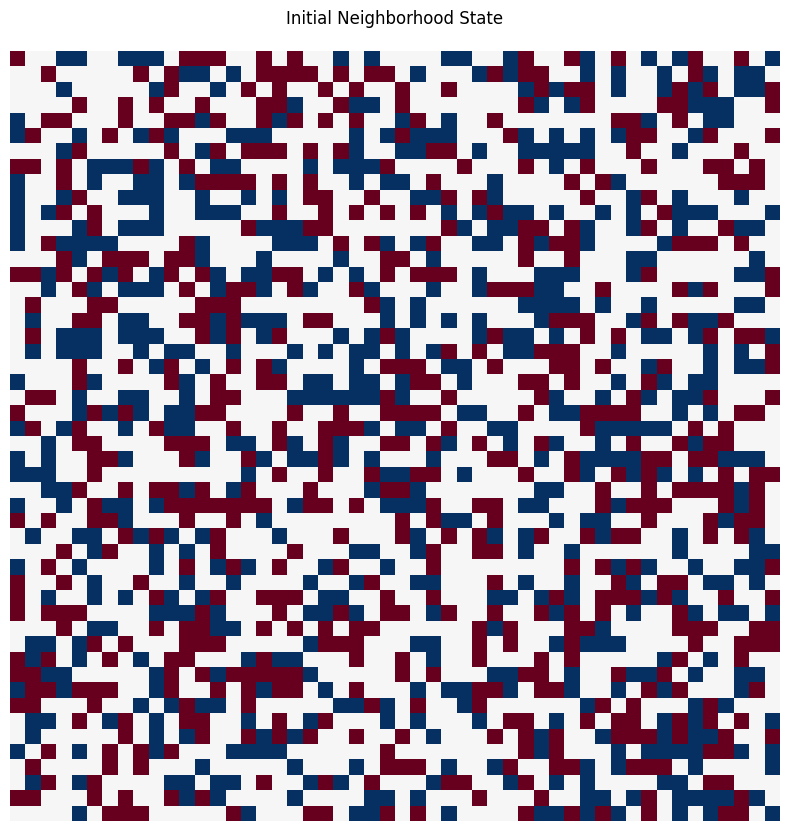

Initial Diversity Index: 0.484

Final State:


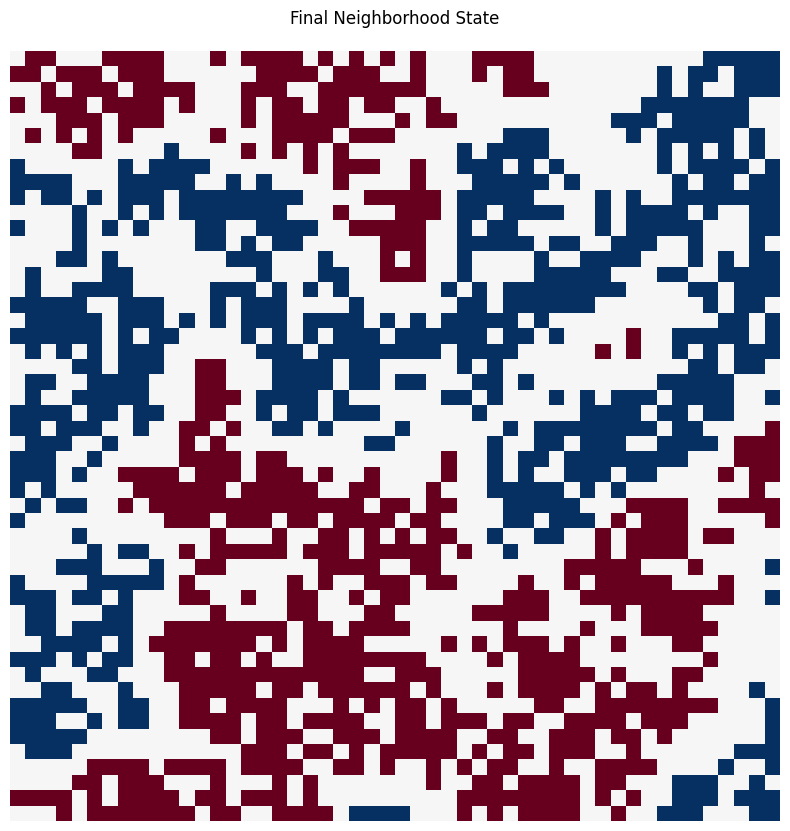

Final Diversity Index: 0.001
Total Relocations: 2978


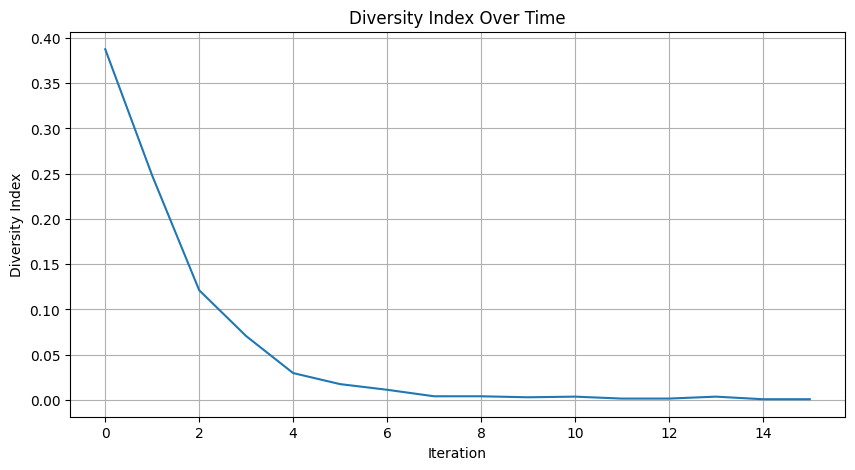

In [11]:
class Resident:
    def __init__(self, community_type):
        self.community_type = community_type
        self.satisfied = False
        self.days_in_location = 0

class Neighborhood:
    def __init__(self, length, breadth, density, community_a_ratio, satisfaction_threshold):
        self.length = length
        self.breadth = breadth
        self.density = density
        self.community_a_ratio = community_a_ratio
        self.satisfaction_threshold = satisfaction_threshold
        self.neighborhood_map = []
        self.available_locations = []
        self.relocation_count = 0
        self.satisfaction_history = []
        self._create_neighborhood()

    def _create_neighborhood(self):
        total_spaces = self.length * self.breadth
        occupied_spaces = int(total_spaces * self.density)
        community_a_count = int(occupied_spaces * self.community_a_ratio)
        community_b_count = occupied_spaces - community_a_count

        residents = (
            [Resident('Community_A') for _ in range(community_a_count)] +
            [Resident('Community_B') for _ in range(community_b_count)]
        )
        random.shuffle(residents)

        self.neighborhood_map = [[None for _ in range(self.length)]
                               for _ in range(self.breadth)]

        all_locations = [(x, y) for x in range(self.breadth)
                        for y in range(self.length)]
        random.shuffle(all_locations)

        for i, loc in enumerate(all_locations[:occupied_spaces]):
            x, y = loc
            self.neighborhood_map[x][y] = residents[i]

        self.available_locations = all_locations[occupied_spaces:]

    def _check_surroundings(self, x, y):
        similar_neighbors = 0
        total_neighbors = 0
        resident = self.neighborhood_map[x][y]

        for dx in [-2, -1, 0, 1, 2]:
            for dy in [-2, -1, 0, 1, 2]:
                if dx == 0 and dy == 0:
                    continue

                new_x, new_y = x + dx, y + dy
                if (0 <= new_x < self.breadth and
                    0 <= new_y < self.length and
                    self.neighborhood_map[new_x][new_y]):

                    total_neighbors += 1
                    if (self.neighborhood_map[new_x][new_y].community_type ==
                        resident.community_type):
                        similar_neighbors += 1

        return (similar_neighbors / total_neighbors >= self.satisfaction_threshold
                if total_neighbors > 0 else False)

    def _relocate_resident(self, x, y):
        if not self.available_locations:
            return False

        new_location = random.choice(self.available_locations)
        self.available_locations.remove(new_location)
        self.available_locations.append((x, y))

        new_x, new_y = new_location
        self.neighborhood_map[new_x][new_y] = self.neighborhood_map[x][y]
        self.neighborhood_map[x][y] = None
        self.relocation_count += 1
        return True

    def calculate_diversity_index(self):
        total_interactions = 0
        diverse_interactions = 0

        for x in range(self.breadth):
            for y in range(self.length):
                if self.neighborhood_map[x][y]:
                    neighbors = []
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            if dx == 0 and dy == 0:
                                continue
                            new_x, new_y = x + dx, y + dy
                            if (0 <= new_x < self.breadth and
                                0 <= new_y < self.length and
                                self.neighborhood_map[new_x][new_y]):
                                neighbors.append(
                                    self.neighborhood_map[new_x][new_y].community_type
                                )

                    total_interactions += len(neighbors)
                    diverse_interactions += len([n for n in neighbors
                        if n != self.neighborhood_map[x][y].community_type])

        return (diverse_interactions / total_interactions
                if total_interactions > 0 else 0)

    def simulate_movement(self, max_iterations=100):
        for iteration in range(max_iterations):
            relocations = 0

            for x in range(self.breadth):
                for y in range(self.length):
                    if (self.neighborhood_map[x][y] and
                        not self._check_surroundings(x, y)):
                        if self._relocate_resident(x, y):
                            relocations += 1

            self.satisfaction_history.append(self.calculate_diversity_index())

            if relocations == 0:
                break

    def visualize_neighborhood(self, title="Neighborhood Map"):
        display_map = np.zeros((self.breadth, self.length))

        for x in range(self.breadth):
            for y in range(self.length):
                if self.neighborhood_map[x][y]:
                    display_map[x][y] = (1 if self.neighborhood_map[x][y].community_type
                                       == 'Community_A' else -1)

        plt.figure(figsize=(10, 10))
        img = plt.imshow(display_map, cmap='RdBu')
        plt.title(title, pad=20)
        plt.axis('off')
        # Explicitly hiding the colorbar
        plt.colorbar(img).remove()
        plt.show()

def run_simulation():
    params = {
        'length': 50,
        'breadth': 50,
        'density': 0.5,
        'community_a_ratio': 0.5,
        'satisfaction_threshold': 0.65
    }

    neighborhood = Neighborhood(**params)

    print("\nInitial State:")
    neighborhood.visualize_neighborhood("Initial Neighborhood State")
    initial_diversity = neighborhood.calculate_diversity_index()
    print(f"Initial Diversity Index: {initial_diversity:.3f}")

    neighborhood.simulate_movement()

    print("\nFinal State:")
    neighborhood.visualize_neighborhood("Final Neighborhood State")
    final_diversity = neighborhood.calculate_diversity_index()
    print(f"Final Diversity Index: {final_diversity:.3f}")
    print(f"Total Relocations: {neighborhood.relocation_count}")

    plt.figure(figsize=(10, 5))
    plt.plot(neighborhood.satisfaction_history)
    plt.title('Diversity Index Over Time')
    plt.xlabel('Iteration')
    plt.ylabel('Diversity Index')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    run_simulation()

## Integrity statement

Please briefly describe all references you used, all help you received and all help you gave to others in completing this assignment. Be sure to say that you got no help if you got none.

FIXME